non clifford
non clifford
non clifford
non clifford
non clifford
non clifford gates number  5
unmeasured length 37
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 1, 36: 2, 37: 2, 38: 1, 39: 3, 40: 3}


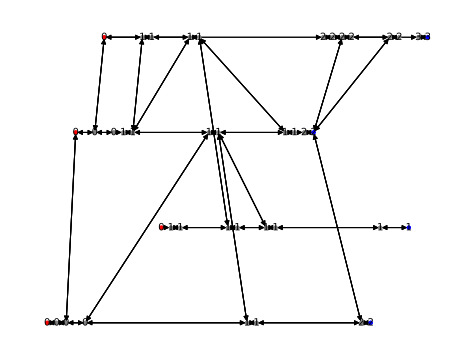

In [2]:
from Partition import *

NQubit = 4
Depth = 20

def main():
    gs, input_nodes, node_pos, colors = generate_graph_state(NQubit, Depth)
    gs = partition(gs, input_nodes)
    labels = nx.get_node_attributes(gs, 'layer')
    nx.draw(gs, pos = node_pos, node_color = colors, node_size = 10, labels = labels,  font_size=10)
    print(labels)
    return

if __name__ == '__main__':
    main()